In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import cm
from pprint import pprint

import statsmodels.api as sm
import seaborn as sns
import feature_processing as fp

from sklearn.decomposition import PCA
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif, mutual_info_classif

%matplotlib inline

In [2]:
data = pd.read_csv('./data/trainset_digitized.csv')

In [3]:
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

In [4]:
binary_fs = [col for col in features.columns if '_bin' in col]
cat_fs = [col for col in features.columns if '_cat' in col]
bin_cat_fs = binary_fs + cat_fs

ordinal_fs = [col for col in features.columns 
              if col not in bin_cat_fs]

bins_cats = features[bin_cat_fs]
ordinals= features[ordinal_fs]

In [9]:
print('# Binary & Categorical Features: %d' % (bins_cats.shape[1]))
print('# Ordinal/continuous Features: %d' % (ordinals.shape[1]))

# Binary & Categorical Features: 201
# Ordinal/continuous Features: 26


## Test Association/Independence with the class labels

<b>Binary and Categorical Features</b>

In [10]:
X_bincat = np.array(bins_cats)
y = np.array(target)

In [32]:
_, chi_pvals = chi2(X_bincat, y)
_, f_pvals = f_classif(X_bincat, y)

In [33]:
%%time
if False:
    minfo = mutual_info_classif(X_bincat, y)

CPU times: user 23min 15s, sys: 5.16 s, total: 23min 20s
Wall time: 23min 19s


In [70]:
pd.Series(minfo).describe(percentiles=[0.25, 0.5, 0.75, 0.9])

count    201.000000
mean       0.006461
std        0.021029
min        0.000000
25%        0.000000
50%        0.000158
75%        0.000458
90%        0.011873
max        0.133032
dtype: float64

In [71]:
chi_001_fs = [bin_cat_fs[i] for i in np.argwhere(chi_pvals < 0.01).ravel()]
chi_005_fs = [bin_cat_fs[i] for i in np.argwhere(chi_pvals < 0.05).ravel()]

F_001_fs = [bin_cat_fs[i] for i in np.argwhere(f_pvals < 0.01).ravel()]
F_005_fs = [bin_cat_fs[i] for i in np.argwhere(f_pvals < 0.05).ravel()]

mi_50_fs = [bin_cat_fs[i] for i in np.argwhere(minfo >= 0.000158).ravel()]
mi_75_fs = [bin_cat_fs[i] for i in np.argwhere(minfo >= 0.000458).ravel()]
mi_90_fs = [bin_cat_fs[i] for i in np.argwhere(minfo >= 0.011873).ravel()]

In [73]:
print('# bins_cats: %d' % (len(bin_cat_fs)))

print('# chi_001: %d' % (len(chi_001_fs)))
print('# chi_005: %d' % (len(chi_005_fs)))

print('# F_001: %d' % (len(F_001_fs)))
print('# F_005: %d' % (len(F_005_fs)))

print('# mi50: %d' % (len(mi_50_fs)))
print('# mi75: %d' % (len(mi_75_fs)))
print('# mi90: %d' % (len(mi_90_fs)))

print('# intersection btw chi001 & F001: %d' % (len(set(chi_001_fs).intersection(F_001_fs))))
print('# intersection btw chi005 & F005: %d' % (len(set(chi_005_fs).intersection(F_005_fs))))

# bins_cats: 201
# chi_001: 115
# chi_005: 131
# F_001: 116
# F_005: 132
# mi50: 101
# mi75: 51
# mi90: 20
# intersection btw chi001 & F001: 115
# intersection btw chi005 & F005: 131


In [89]:
%%time
bins_cats.loc[:, chi_001_fs].to_csv('./data/class_associated_bincat_features_chi001.csv', index=False)
bins_cats.loc[:, chi_005_fs].to_csv('./data/class_associated_bincat_features_chi005.csv', index=False)

bins_cats.loc[:, F_001_fs].to_csv('./data/class_associated_bincat_features_F001.csv', index=False)
bins_cats.loc[:, F_005_fs].to_csv('./data/class_associated_bincat_features_F005.csv', index=False)

bins_cats.loc[:, mi_50_fs].to_csv('./data/class_associated_bincat_features_mi50.csv', index=False)
bins_cats.loc[:, mi_75_fs].to_csv('./data/class_associated_bincat_features_mi75.csv', index=False)
bins_cats.loc[:, mi_90_fs].to_csv('./data/class_associated_bincat_features_mi90.csv', index=False)

CPU times: user 1min 48s, sys: 2 s, total: 1min 50s
Wall time: 1min 51s


In [98]:
bincat_scores = pd.DataFrame({'Chi': chi_pvals, 'F': f_pvals, 'Mutual_Info': minfo},
                              columns=['Chi', 'F', 'Mutual_Info'], index=bin_cat_fs)

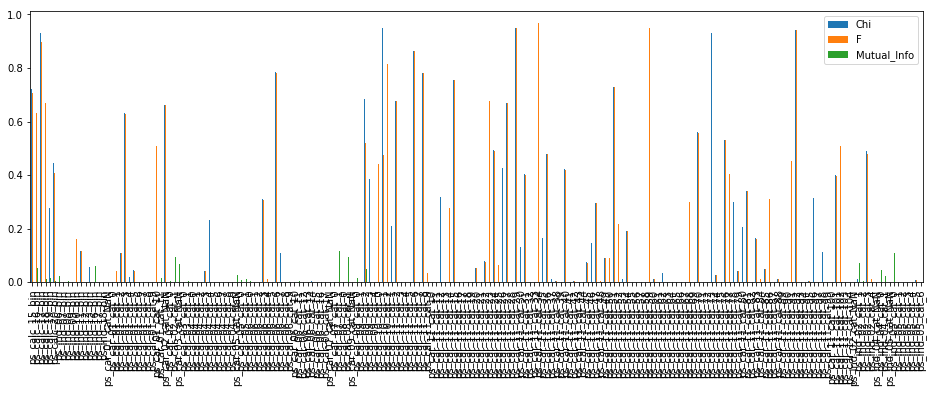

In [101]:
bincat_scores.plot(kind='bar', figsize=(16, 5))

<b>Ordinal and Digitized Continuous Features</b>

In [79]:
d = pd.concat([ordinals, target], axis=1).replace({-1:np.NaN})

X_ord = np.array(ordinals)
y = np.array(target)

In [85]:
_, f_pvals2 = f_classif(X_ord, y)

In [83]:
%%time
if True:
    minfo2 = mutual_info_classif(X_ord, y)

CPU times: user 2min 57s, sys: 562 ms, total: 2min 58s
Wall time: 2min 58s


In [86]:
pd.Series(minfo2).describe(percentiles=[0.25, 0.5, 0.75, 0.9])

count    26.000000
mean      0.018231
std       0.012065
min       0.000000
25%       0.012220
50%       0.014046
75%       0.026079
90%       0.029277
max       0.057306
dtype: float64

In [87]:
F_001_fs2 = [ordinal_fs[i] for i in np.argwhere(f_pvals2 < 0.01).ravel()]
F_005_fs2 = [ordinal_fs[i] for i in np.argwhere(f_pvals2 < 0.05).ravel()]

mi_50_fs2 = [ordinal_fs[i] for i in np.argwhere(minfo2 >= 0.014046).ravel()]
mi_75_fs2 = [ordinal_fs[i] for i in np.argwhere(minfo2 >= 0.026079).ravel()]
mi_90_fs2 = [ordinal_fs[i] for i in np.argwhere(minfo2 >= 0.029277).ravel()]

In [88]:
print('# bins_cats: %d' % (len(ordinal_fs)))

print('# F_001: %d' % (len(F_001_fs2)))
print('# F_005: %d' % (len(F_005_fs2)))

print('# mi50: %d' % (len(mi_50_fs2)))
print('# mi75: %d' % (len(mi_75_fs2)))
print('# mi90: %d' % (len(mi_90_fs2)))

# bins_cats: 26
# F_001: 11
# F_005: 11
# mi50: 13
# mi75: 7
# mi90: 3


In [90]:
%%time
ordinals.loc[:, F_001_fs2].to_csv('./data/class_associated_ordinal_features_F001.csv', index=False)
ordinals.loc[:, F_005_fs2].to_csv('./data/class_associated_ordinal_features_F005.csv', index=False)

ordinals.loc[:, mi_50_fs2].to_csv('./data/class_associated_ordinal_features_mi50.csv', index=False)
ordinals.loc[:, mi_75_fs2].to_csv('./data/class_associated_ordinal_features_mi75.csv', index=False)
ordinals.loc[:, mi_90_fs2].to_csv('./data/class_associated_ordinal_features_mi90.csv', index=False)

CPU times: user 11.3 s, sys: 70.9 ms, total: 11.4 s
Wall time: 11.4 s


In [104]:
ordinal_scores = pd.DataFrame({'F': f_pvals2, 'Mutual_Info': minfo2},
                              columns=['F', 'Mutual_Info'], index=ordinal_fs)

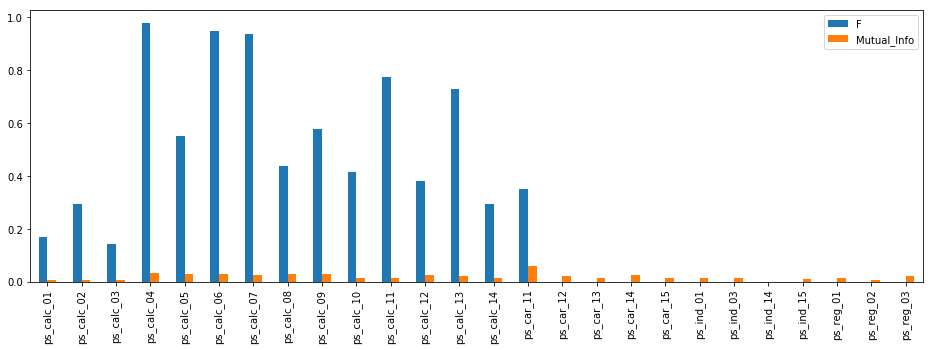

In [105]:
ordinal_scores.plot(kind='bar', figsize=(16, 5))

## Conclusion
Overall, it appears that the results here with Chi-square and F-score are pretty much the same as my previous analysis (Chi-square should be for sure). It may be useful to try including some features that had higher mutual_info than others.